In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import os
import seaborn as sns
from scipy import stats
import sys
sys.path.append('..')
from madule import simulation
from madule import plots
from statsmodels.stats.anova import AnovaRM

In [24]:
# read collected data across data
behAll = pd.read_csv('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/AllBehData/behAll.csv')
# rearrange trial number
behAll['trialNumber'].replace(
       [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85],
       [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], inplace=True)

# Take color value learning and one reversal point
block = 'Stim'
reverse =  21
behAllCond = behAll.loc[(behAll['block']==block)&(behAll['reverse']==reverse)]

if block=='Stim' and reverse==21: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['yellowChosen']-1)
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['yellowChosen']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['yellowChosen']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['yellowChosen']
    behAllCond['highReward'] = highReward
    
    # Switch choice responses to proportional choices for Color value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Act'] = behAllCond.loc[behAllCond['stimActFirst']=='Act']['yellowChosen']
    chosenOption[behAllCond['stimActFirst']=='Stim'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Stim']['yellowChosen']-1)
    behAllCond['chosenOption'] = chosenOption
    
elif block=='Act' and reverse==21: 
    # Switch choice responses into correct choices for Color value learning
    highReward = np.zeros(behAllCond.shape[0]) 
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['pushed']-1)
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = -(behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['pushed']-1)
    highReward[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)] = behAllCond.loc[(behAllCond['stimActFirst']=='Stim')&(behAllCond['trialNumber']>=23)&(behAllCond['trialNumber']<=43)]['pushed']
    highReward[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)] = behAllCond.loc[(behAllCond['stimActFirst']=='Act')&(behAllCond['trialNumber']>=2)&(behAllCond['trialNumber']<=22)]['pushed']
    behAllCond['highReward'] = highReward

    # Switch choice responses to proportional choices for Action value learning
    chosenOption = np.zeros(behAllCond.shape[0]) 
    chosenOption[behAllCond['stimActFirst']=='Act'] = behAllCond.loc[behAllCond['stimActFirst']=='Act']['pushed']
    chosenOption[behAllCond['stimActFirst']=='Stim'] = -(behAllCond.loc[behAllCond['stimActFirst']=='Stim']['pushed']-1)
    behAllCond['chosenOption'] = chosenOption


/tmp/ipykernel_2090170/1046606670.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behAllCond['highReward'] = highReward
/tmp/ipykernel_2090170/1046606670.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behAllCond['chosenOption'] = chosenOption


In [25]:
"""Medication Effect"""
# Window size for moving average
window_size = 5

"""hight rewarding correct choices"""
# Average of hight rewarding correct choices Across participants for each trial
behAllCond_highReward = behAllCond.groupby(['group', 'trialNumber'], as_index=False)['highReward'].mean()


# high rewarding correct option for each trial and moving average in group 1
x_1_highReward = behAllCond_highReward[behAllCond_highReward['group']==1]['trialNumber'] -1
mean_1_highReward = behAllCond_highReward[behAllCond_highReward['group']==1]['highReward']
windows_mean_1_highReward = mean_1_highReward.rolling(window=window_size, min_periods=1)
moving_averages_mean_1_highReward = windows_mean_1_highReward.mean()

# high rewarding correct option for each trial and moving average in group 2
x_2_highReward = behAllCond_highReward[behAllCond_highReward['group']==2]['trialNumber'] -1
mean_2_highReward = behAllCond_highReward[behAllCond_highReward['group']==2]['highReward']
windows_mean_2_highReward = mean_2_highReward.rolling(window=window_size, min_periods=1)
moving_averages_mean_2_highReward = windows_mean_2_highReward.mean()

# high rewarding correct option for each trial and moving average in group 3
x_3_highReward= behAllCond_highReward[behAllCond_highReward['group']==3]['trialNumber'] -1
mean_3_highReward = behAllCond_highReward[behAllCond_highReward['group']==3]['highReward']
windows_mean_3_highReward = mean_3_highReward.rolling(window=window_size, min_periods=1)
moving_averages_mean_3_highReward = windows_mean_3_highReward.mean()


"""hight rewarding correct choices"""
# Average of chosen options Across participants for each trial
behAllCond_chosenOption = behAllCond.groupby(['group', 'trialNumber'], as_index=False)['chosenOption'].mean()
 
# Assignment of x and y values from the mean across subject for each trial
x_1_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==1]['trialNumber'] -1
y_1_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==1]['chosenOption']
windows_y_1_chosenOption = y_1_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_1_chosenOption = windows_y_1_chosenOption.mean()
  
x_2_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==2]['trialNumber'] -1
y_2_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==2]['chosenOption']
windows_y_2_chosenOption = y_2_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_2_chosenOption = windows_y_2_chosenOption.mean()

x_3_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==3]['trialNumber'] -1
y_3_chosenOption = behAllCond_chosenOption[behAllCond_chosenOption['group']==3]['chosenOption']
windows_y_3_chosenOption = y_3_chosenOption.rolling(window=window_size, min_periods=1)
moving_averages_y_3_chosenOption = windows_y_3_chosenOption.mean()


"""Rewarded points"""
# Average of rewarded points Across participants for each trial
behAllCond_correctChoice = behAllCond.groupby(['group', 'trialNumber'], as_index=False)['correctChoice'].mean()
  
# Assignment of x and y values from the mean across subject for each trial
x_1_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==1]['trialNumber'] -1
y_1_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==1]['correctChoice']
windows_y_1_correctChoice = y_1_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_1_correctChoice = windows_y_1_correctChoice.mean()
  
x_2_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==2]['trialNumber'] -1
y_2_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==2]['correctChoice']
windows_y_2_correctChoice = y_2_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_2_correctChoice = windows_y_2_correctChoice.mean()

x_3_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==3]['trialNumber'] -1
y_3_correctChoice = behAllCond_correctChoice[behAllCond_correctChoice['group']==3]['correctChoice']
windows_y_3_correctChoice = y_3_correctChoice.rolling(window=window_size, min_periods=1)
moving_averages_y_3_correctChoice = windows_y_3_correctChoice.mean()
 

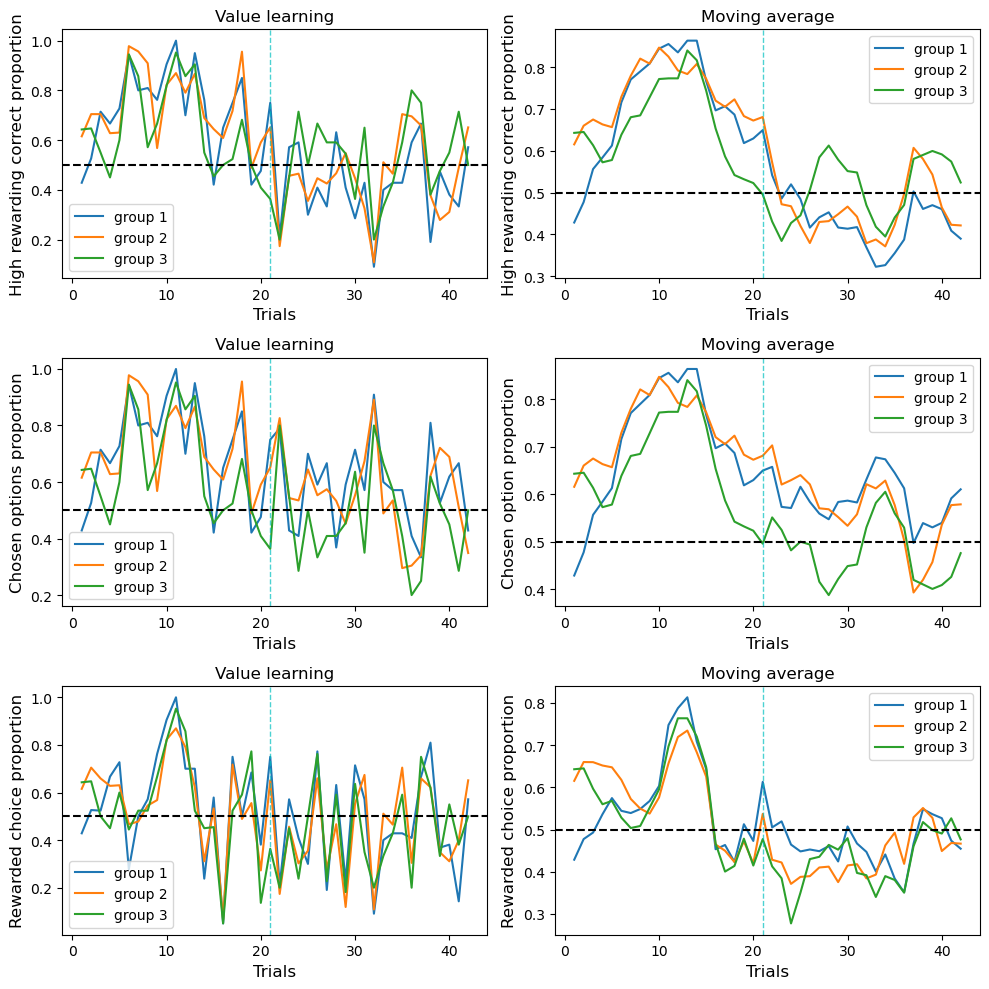

In [26]:
fig = plt.figure(figsize=(10,10), tight_layout=True)
row = 3
column = 2

fig.add_subplot(row, column, 1)
plt.plot(x_1_highReward, mean_1_highReward)
plt.plot(x_2_highReward, mean_2_highReward)
plt.plot(x_3_highReward, mean_3_highReward)
plt.title('Value learning')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('High rewarding correct proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)

fig.add_subplot(row, column, 2)
plt.plot(x_1_highReward, moving_averages_mean_1_highReward)
plt.plot(x_2_highReward, moving_averages_mean_2_highReward)
plt.plot(x_3_highReward, moving_averages_mean_3_highReward)
plt.title('Moving average')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('High rewarding correct proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)
 
fig.add_subplot(row, column, 3)
plt.plot(x_1_chosenOption, y_1_chosenOption)
plt.plot(x_2_chosenOption, y_2_chosenOption)
plt.plot(x_3_chosenOption, y_3_chosenOption)
plt.title('Value learning')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Chosen options proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)

fig.add_subplot(row, column, 4)
plt.plot(x_1_chosenOption, moving_averages_y_1_chosenOption)
plt.plot(x_2_chosenOption, moving_averages_y_2_chosenOption)
plt.plot(x_3_chosenOption, moving_averages_y_3_chosenOption)
plt.title('Moving average')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Chosen option proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)

fig.add_subplot(row, column, 5)
plt.plot(x_1_correctChoice, y_1_correctChoice)
plt.plot(x_2_correctChoice, y_2_correctChoice)
plt.plot(x_3_correctChoice, y_3_correctChoice)
plt.title('Value learning')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Rewarded choice proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)

fig.add_subplot(row, column, 6)
plt.plot(x_1_correctChoice, moving_averages_y_1_correctChoice)
plt.plot(x_2_correctChoice, moving_averages_y_2_correctChoice)
plt.plot(x_3_correctChoice, moving_averages_y_3_correctChoice)
plt.title('Moving average')
plt.xlabel('Trials', fontsize='12')
plt.ylabel('Rewarded choice proportion', fontsize='12')
plt.legend(['group 1', 'group 2', 'group 3'])
plt.axhline(y=.5, color='black' , linestyle='--')
plt.axvline(x = 21, color='c', linestyle='--', linewidth=1, alpha=.7)



In [27]:
# Averaging Across participants for each trial
group1 = behAllCond[(behAllCond['group']==1)&(behAllCond['trialNumber']<=21)]
group1 = group1.groupby(['sub_ID', 'group'], as_index=False)['highReward'].mean()

group3 = behAllCond[(behAllCond['group']==3)&(behAllCond['trialNumber']<=21)]
group3 = group3.groupby(['sub_ID', 'group'], as_index=False)['highReward'].mean()

group2 = behAllCond[(behAllCond['group']==2)&(behAllCond['trialNumber']<=21)]
group2 = group2.groupby(['sub_ID', 'group'], as_index=False)['highReward'].mean()

stats.ttest_rel(group1['highReward'], group3['highReward'])

TtestResult(statistic=1.6067484387689897, pvalue=0.1230424776139537, df=21)

In [19]:
# Averaging Across participants for each trial
part1 = behAllCond[(behAllCond['trialNumber']<=22)]
part1 = part1.groupby(['sub_ID'], as_index=False)['highReward'].mean()

part2 = behAllCond[(behAllCond['trialNumber']>=23)]
part2 = part2.groupby(['sub_ID'], as_index=False)['highReward'].mean()

stats.ttest_rel(part1['highReward'], part2['highReward'])

TtestResult(statistic=4.976148922604124, pvalue=9.959058053622814e-06, df=45)

In [79]:
part1['highRewardClr'].mean(), part2['highRewardClr'].mean()

(0.5673232123515446, 0.43599321495871735)

$P(Y=1) = a \cdot e^{-b \cdot e^{cx}}$

Where:
- \(P(Y=1)\) is the probability of the event occurring.
- \(e\) is the base of the natural logarithm.
- \(a\), \(b\), and \(c\) are parameters that determine the shape of the curve.
- \(x\) represents your predictor variable(s).

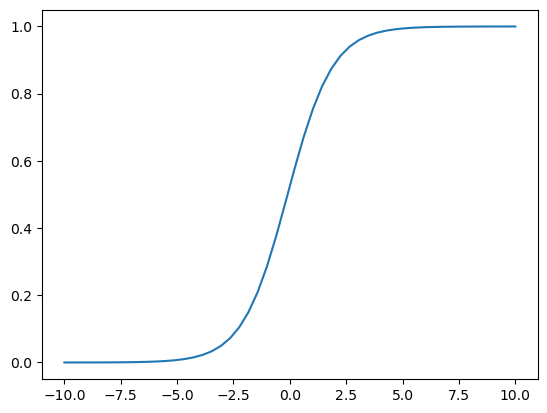

In [126]:
plt.plot(x, 1/(1+np.exp(-1*x-.1)))

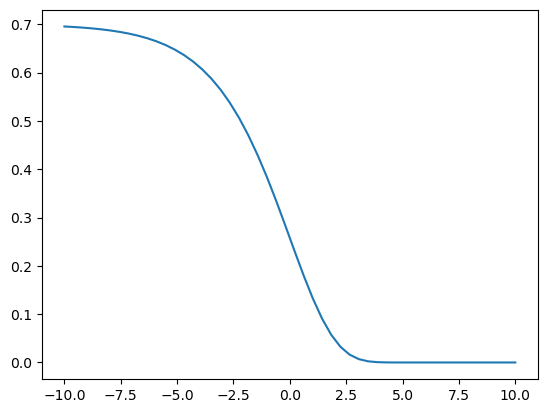

In [139]:
x = np.linspace(-10, 10)
plt.plot(x, .7*np.exp(-1*np.exp(.5*x)))